In [ ]:
!pip install pennylane --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 957 kB 5.3 MB/s 
     |████████████████████████████████| 1.6 MB 27.6 MB/s 
     |████████████████████████████████| 9.3 MB 17.5 MB/s 
     |████████████████████████████████| 108 kB 36.4 MB/s 


In [ ]:
import pennylane as qml
import pennylane.numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchvision.datasets import CIFAR10

from sklearn.decomposition import PCA

from google.colab import drive
drive.mount('/content/drive')


import time
import datetime


Mounted at /content/drive


In [ ]:
class MakingDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __getitem__(self, index):
    image = self.X[index]
    label = self.y[index]
    return image, label

  def __len__(self):
      return len(self.y)


class TrainTestLoader(object):
  def __init__(self, data_type="CIFAR10"):
    self.data = data_type

    self.training_data=None
    self.test_data=None

    self.train_X = None
    self.train_y = None
    self.test_X = None
    self.test_y = None

    if self.data == "CIFAR10":
      download_root = "./CIFAR10_DATASET"
      CIFAR10_transform = transforms.Compose([
                    transforms.ToTensor()
                  ])
      self.training_data = CIFAR10(download_root,
                        train=True,
                        download=True,
                        transform=CIFAR10_transform)

      self.test_data = CIFAR10(download_root,
                        train=False,
                        download=True,
                        transform=CIFAR10_transform)

      train_X = torch.Tensor(self.training_data.data) / 255.0
      train_y = torch.Tensor(self.training_data.targets)

      test_X = torch.Tensor(self.test_data.data) / 255.0
      test_y = torch.Tensor(self.test_data.targets)

      # cat(index=3), dog(index=5)에 해당하는 데이터만 추출
      self.train_X = train_X[(train_y==3) | (train_y==5)]
      self.train_y = train_y[(train_y==3) | (train_y==5)]
      self.test_X = test_X[(test_y==3) | (test_y==5)]
      self.test_y = test_y[(test_y==3) | (test_y==5)]

      # cat은 0으로 dog는 1로 index변환
      self.train_y = torch.where(self.train_y==3, 0, 1)
      self.test_y = torch.where(self.test_y==3, 0, 1)


  def scale_pca(self, n_dim):
    
    ###여기에 standardscaler 있었는데 그냥 안 함

    if self.data == "CIFAR10":
      train_shape = self.train_X.shape
      test_shape = self.test_X.shape
      train_X = self.train_X.reshape((train_shape[0],
                                      train_shape[1]*train_shape[2],
                                      train_shape[3]))
      test_X = self.test_X.reshape((test_shape[0],
                                      test_shape[1]*test_shape[2],
                                      test_shape[3]))
      train_X_pca =\
                np.zeros((train_shape[0], n_dim, train_shape[3]))
      test_X_pca =\
                np.zeros((test_shape[0], n_dim, test_shape[3]))
      #channel별로 pca적용
      for channel in range(train_shape[-1]):
        pca = PCA(n_components = n_dim)
        train_X_pca[:,:,channel] = pca.fit_transform(train_X[:,:,channel])
        test_X_pca[:,:,channel] = pca.transform(test_X[:,:,channel])
      self.train_X = torch.Tensor(train_X_pca)
      self.test_X = torch.Tensor(train_X_pca)

  
  def scale_resize(self, size):

    if self.data == "CIFAR10":
      size = int(np.sqrt(size))
      t = transforms.Resize(size=(size, size))
      train_X_p = self.train_X.permute(0,3,1,2)
      test_X_p = self.test_X.permute(0,3,1,2)
      train_X = t(train_X_p).permute(0,2,3,1)
      test_X = t(test_X_p).permute(0,2,3,1)

      self.train_X = train_X.reshape((train_X.shape[0],
                                     train_X.shape[1]*train_X.shape[2],
                                      train_X.shape[3]))
      self.test_X = test_X.reshape((test_X.shape[0],
                                     test_X.shape[1]*test_X.shape[2],
                                      test_X.shape[3]))


  def return_dataset(self):
      return MakingDataset(self.train_X, self.train_y), MakingDataset(self.test_X, self.test_y)


  # def save(self):
  #     self.training_data.to_csv("./training_data.csv", index = False)
  #     self.test_data.to_csv("./test_data.csv", index = False)

  # def load(self):
  #     self.training_data = read_csv("./training_data.csv")
  #     self.test_data = read_csv("./test_data.csv")



In [ ]:
#QCNN_circuit

class QCNN():
  def __init__(self, n_qubits, conv_ansatz, pooling_ansatz, final_ansatz):
    if conv_ansatz == "ConvCirc1":
      self.conv_ansatz = ConvCirc1()
    elif conv_ansatz == "ConvCircSU4":
      self.conv_ansatz = ConvCircSU4()

    self.pooling_ansatz = pooling_ansatz
    self.n_qubits = n_qubits

    self.final_ansatz = final_ansatz

  def construct_circuit(self, params, final_params, data):
    # insert initial state as data in n_qubits, not total_qubits
    # qml.AmplitudeEmbedding(tensor_of_012, wires=range(self.n_qubits),
    #                        pad_with=0, normalize=True)

    data = torch.flatten(data.T)
    qml.AngleEmbedding(features=data, wires = range(12),
                       rotation = "X")
    
    ansatz_param_num = self.conv_ansatz.num_params
    #circuit0 parameters
    param0_1 = params[0, 0:ansatz_param_num]
    param0_2 = params[0, ansatz_param_num: 2 * ansatz_param_num]

    param0_3 = params[0, 2 * ansatz_param_num: 2 * ansatz_param_num + 2]
    param0_4 = params[0, 2 * ansatz_param_num + 2: 2 * ansatz_param_num + 4]

    #circuit1 parameters
    param1_1 = params[1, 0:ansatz_param_num]
    param1_2 = params[1, ansatz_param_num: 2 * ansatz_param_num]

    param1_3 = params[1, 2 * ansatz_param_num: 2 * ansatz_param_num + 2]
    param1_4 = params[1, 2 * ansatz_param_num + 2: 2 * ansatz_param_num + 4]

    #circuit2 parameters
    param2_1 = params[2, 0:ansatz_param_num]
    param2_2 = params[2, ansatz_param_num: 2 * ansatz_param_num]

    param2_3 = params[2, 2 * ansatz_param_num: 2 * ansatz_param_num + 2]
    param2_4 = params[2, 2 * ansatz_param_num + 2: 2 * ansatz_param_num + 4]
    

    #circuit3 - final circuit parameters
    param3 = final_params


    self.conv_layer1(param0_1,param1_1,param2_1)
    self.pooling_layer1(param0_3, param1_3, param2_3)

    self.conv_layer2(param0_2, param1_2, param2_2)
    self.pooling_layer2(param0_4, param1_4, param2_4)

    self.final_layer(param3)


  # Convolutional layers
  def conv_layer1(self, params0, params1, params2):
    for channel in range(3):
      ch = channel * 4
      if channel == 0:
        parameter = params0
      elif channel == 1:
        parameter = params1
      elif channel == 2:
        parameter = params2
      self.conv_ansatz.apply(parameter, wires=[0+ch, 1 + ch])
      self.conv_ansatz.apply(parameter, wires=[2+ch, 3 + ch])
      self.conv_ansatz.apply(parameter, wires=[0+ch, 3 + ch])
      self.conv_ansatz.apply(parameter, wires=[1+ch, 2 + ch])

  def conv_layer2(self, params0, params1, params2):
    for channel in range(3):
      ch = channel * 4
      if channel == 0:
        parameter = params0
      elif channel == 1:
        parameter = params1
      elif channel == 2:
        parameter = params2
      self.conv_ansatz.apply(parameter, wires=[0+ch, 2+ch])

  # Pooling layers
  def pooling_layer1(self, params0, params1, params2):
    for channel in range(3):
      ch = channel * 4
      if channel == 0:
        parameter = params0
      elif channel == 1:
        parameter = params1
      elif channel == 2:
        parameter = params2
      self.pooling_ansatz.apply(parameter, wires=[1+ch, 0+ch])
      self.pooling_ansatz.apply(parameter, wires=[3+ch, 2+ch])      

  def pooling_layer2(self, params0, params1, params2):
    for channel in range(3):
      ch = channel * 4
      if channel == 0:
        parameter = params0
      elif channel == 1:
        parameter = params1
      elif channel == 2:
        parameter = params2
      self.pooling_ansatz.apply(parameter, wires=[2+ch, 0+ch])

  #fianly layer - 3개의 채널에서 나온 결과를 종합
  def final_layer(self, param3):
    self.final_ansatz.apply(param3, wires = [0, 4, 8])


  # param과 final param의 크기 계산해서 return
  def Calculate_Param_Num(self):
    ansatz_param = self.conv_ansatz.num_params
    pooling_param = self.pooling_ansatz.num_params
    total_param_num = ansatz_param*3 + pooling_param*3
    return (3, total_param_num), self.final_ansatz.num_params


# def estimated_label(params, data):
#     return circuit(params, data) 



In [ ]:
## ansatz 여기에서 추가 가능

# Convolutional Layer Ansatz
class ConvCirc1():
  def __init__(self) -> None:
    self.num_params = 2

  def apply(self, weights, wires):
    qml.RY(weights[0], wires = wires[0])
    qml.RY(weights[1], wires = wires[1])
    qml.CNOT(wires = wires)

# Convolutional Layer Ansatz SU(4)
class ConvCircSU4():

  def __init__(self) -> None:
      self.num_params = 15

  def apply(self, weights, wires):
      qml.U3(weights[0], weights[1], weights[2], wires = wires[0])
      qml.U3(weights[3], weights[4], weights[5], wires = wires[1])
      qml.CNOT(wires = [wires[0], wires[1]])
      qml.RY(weights[6], wires = wires[0])
      qml.RZ(weights[7], wires = wires[1])
      qml.CNOT(wires = [wires[1], wires[0]])
      qml.RY(weights[8], wires=wires[0])
      qml.CNOT(wires = [wires[0], wires[1]])
      qml.U3(weights[9], weights[10], weights[11], wires = wires[0])
      qml.U3(weights[12], weights[13], weights[14], wires = wires[1])

# Pooling Layer Ansatz
class PoolingCirc():
    def __init__(self) -> None:
        self.num_params = 2
    
    def apply(self, weights, wires):
        qml.CRY(weights[0], wires = wires)
        qml.PauliX(wires[0])
        qml.CRY(weights[1], wires = wires)
        qml.PauliX(wires[0])

# final layer ansatz
class FinalCirc():  #ConvCircSU4변형
  def __init__(self)->None:
    self.num_params = 18
  def apply(self, weights, wires):
    qml.U3(weights[0], weights[1], weights[2], wires = wires[0])
    qml.U3(weights[3], weights[4], weights[5], wires = wires[1])
    qml.CNOT(wires = [wires[0], wires[1]])
    qml.RY(weights[6], wires = wires[0])
    qml.RZ(weights[7], wires = wires[1])
    qml.CNOT(wires = [wires[1], wires[0]])
    qml.RY(weights[8], wires=wires[0])
    qml.CNOT(wires = [wires[0], wires[1]])

    qml.U3(weights[9], weights[10], weights[11], wires = wires[1])
    qml.U3(weights[12], weights[13], weights[14], wires = wires[2])
    qml.CNOT(wires = [wires[1], wires[2]])
    qml.RY(weights[15], wires = wires[1])
    qml.RZ(weights[16], wires = wires[2])
    qml.CNOT(wires = [wires[2], wires[1]])
    qml.RY(weights[17], wires=wires[1])
    qml.CNOT(wires = [wires[2], wires[1]])




In [ ]:
## train 준비
from torch.nn import MSELoss, CrossEntropyLoss
from torch.optim import Adam, Adagrad
from torch.utils.data import random_split

import os
import torchvision
import torchvision.transforms as transforms

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

##################  hyperparam  ##################
EPOCHS = 3
BATCH_SIZE = 25
SEED = 42
LEARNING_RATE = 0.01

VAL_SIZE = 1000

conv_ansatz = "ConvCircSU4"
##################  hyperparam  ##################
###########hyperparam 몇개 생략함######

qcnn = QCNN(n_qubits=12, conv_ansatz= conv_ansatz,
            pooling_ansatz = PoolingCirc(), final_ansatz = FinalCirc())

dev = qml.device("default.qubit", wires=qcnn.n_qubits)
@qml.qnode(dev, interface="torch")
def circuit(params, final_params, data):
  qcnn.construct_circuit(params,final_params, data)
  return qml.expval(qml.PauliZ(4))


###내 방식대로 수정함
loader = TrainTestLoader("CIFAR10")
###### loader.scale_pca( n_dim =? ) or loader.resize(size=?) 중에서 선택 #######
loader.scale_pca(n_dim=4)
training_set, test_set = loader.return_dataset()


training_loader = \
        DataLoader(training_set, batch_size=BATCH_SIZE,
        shuffle=True, generator=torch.Generator().manual_seed(SEED))
# validation_loader = \
#         DataLoader(validation_set, batch_size=len(validation_set),
#         shuffle=False, generator=torch.Generator().manual_seed(SEED))
test_loader = \
        DataLoader(test_set, batch_size=len(test_set),
        shuffle=False, generator=torch.Generator().manual_seed(SEED))

# Report data sizes
print(f"Train set #:      {len(training_set)}")
# print(f"Validation set #: {len(validation_set)}")
print(f"Test set #:       {len(test_set)}")

loss_fn = MSELoss()

param_num, final_param_num = qcnn.Calculate_Param_Num()

params = torch.rand(param_num ,
                    requires_grad=True,
                    generator=torch.Generator().manual_seed(SEED))
final_params = torch.rand(final_param_num ,
                    requires_grad=True,
                    generator=torch.Generator().manual_seed(SEED))

optimizer = Adam([params, final_params], lr =LEARNING_RATE)


Files already downloaded and verified
Files already downloaded and verified
Train set #:      10000
Test set #:       2000


In [ ]:
## train
from tqdm.notebook import tqdm
import logging
import datetime
from pathlib import Path

##################### 할 때마다 file path 고치기 #####################
filepath = "/content/drive/MyDrive/박경덕교수님연구실/MY_QCNN/" +\
            "3Channel_"+conv_ansatz+"_result"
if os.path.exists(filepath) == False:
    os.makedirs(filepath)
def estimated_label(params, fianl_params, data):
    return circuit(params, fianl_params, data) # TODO: customize your extimated label

writer = SummaryWriter(log_dir=filepath)




# loss_list = []
# avg_loss_list = []
# avg_vloss_list = []
# history_of_parameters = []


##############epoch만큼 trianing#######################

# for epoch in range(EPOCHS):
#   avg_loss = 0.0
#   for i, data in tqdm(enumerate(training_loader),
#                       total=len(training_loader), desc=f"{epoch+1}"):
#     inputs, labels = data
#     optimizer.zero_grad()
#     loss = torch.tensor(0, dtype=torch.float64)
#     for input, label in zip(inputs, labels):
#         output = estimated_label(params, input.to(torch.float64))
#         loss+=loss_fn(output, 2*label.to(torch.float64)-1)/len(labels)
#     loss.backward()
#     optimizer.step()
#     avg_loss += loss.item()
#     loss_list.append(loss.item())
#     writer.add_scalar('local training loss',
#                       loss.item(), epoch*len(training_loader)+i)
#     np.save(filepath+'/'+f'epoch{epoch}_iter{epoch*len(training_loader)+i}',
#             params.detach().numpy())
#     # logger.debug("epoch: {} batch_index: {} --- loss: {} \t params: {}".format(epoch+1, i+1, loss.item(), params.detach().numpy()))

#   avg_loss = avg_loss/len(training_loader)
#   avg_loss_list.append(avg_loss)
  
  
#   with torch.no_grad():
#     avg_vloss = 0.0
#     #val_score는 내가 추가
#     val_score = 0
#     for i, vdata in enumerate(validation_loader):
#       vloss = torch.tensor(0, dtype=torch.float64)
#       vinputs, vlabels = vdata
#       for vinput, vlabel in zip(vinputs, vlabels):
#         voutput = estimated_label(params, vinput.to(torch.float64))
#         val_label = 2*vlabel.to(torch.float64)-1
#         vloss += loss_fn(voutput, val_label)/len(vlabels)
#         if np.abs(voutput - val_label) < 1:
#           val_score += 1
#       avg_vloss += vloss.item()
#     avg_vloss = avg_vloss / len(validation_set)
#     avg_vloss_list.append(avg_vloss)
#     history_of_parameters.append(params.numpy())
#     np.save(filepath+'/'+f'vaidataion_epoch{epoch}', params.numpy())
#   # print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
  
#     val_score = val_score / len(validation_set)
#     print(f"Epoch {epoch} val score = {val_score}")

#   # Log the running loss averaged per batch
#   # for both training and test
#   writer.add_scalar('validation Loss', avg_vloss, epoch)
#   writer.flush()
#       # print('{}: {}'.format(i, loss.item()))




In [ ]:
#200 iter만 training

def training_during_num_iter(iter_num):
  start_t = time.time()
  loss_list = []
  avg_vloss_list = []
  history_of_parameters = []
  for i, data in enumerate(training_loader):
    if i == iter_num:
      break
      
    inputs, labels = data
    optimizer.zero_grad()
    loss = torch.tensor(0, dtype=torch.float64)
    for input, label in zip(inputs, labels):
        output = estimated_label(params, final_params, input.to(torch.float64))
        loss+=loss_fn(output, 2*label.to(torch.float64)-1)/len(labels)
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())
    writer.add_scalar('training loss', loss.item(), i)
    np.save(filepath+'/'+f'iter{i}', params.detach().numpy())
    # logger.debug("epoch: {} batch_index: {} --- loss: {} \t params: {}".format(epoch+1, i+1, loss.item(), params.detach().numpy()))
    if (i+1)%10 == 0:
      print(f"Iteration {i+1:>3} loss: {loss.item()}")
  
  end_t = time.time()
  sec = end_t - start_t
  total_time = str(datetime.timedelta(seconds = sec)).split(".")[0]
  print(f"Training during {iter_num} iterations finishes (taken time: {total_time}) ")
  return loss_list, total_time



In [ ]:
######################## training start #########################
## iteration 몇번 할지 지정
iter_num=200

loss_list, total_time = training_during_num_iter(iter_num=iter_num)



Iteration  10 loss: 0.9939737392476361
Iteration  20 loss: 0.9805968699832079
Iteration  30 loss: 1.0346467013555125
Iteration  40 loss: 0.9908604969706055
Iteration  50 loss: 0.971931004208647
Iteration  60 loss: 0.9089096450924133
Iteration  70 loss: 1.086772590552616
Iteration  80 loss: 1.024726556652308
Iteration  90 loss: 1.053249942894816
Iteration 100 loss: 0.9509467450355547
Iteration 110 loss: 0.8941028112748838
Iteration 120 loss: 0.9677395245653443
Iteration 130 loss: 1.078276394290598
Iteration 140 loss: 0.9879822350186964
Iteration 150 loss: 0.9827818287734479
Iteration 160 loss: 1.0034839068511314
Iteration 170 loss: 1.0923372522506951
Iteration 180 loss: 0.9845105858478195
Iteration 190 loss: 1.0041378764575328
Iteration 200 loss: 0.9746618919330634
Training during 200 iterations finishes (taken time: 0:36:19) 


In [ ]:
# test_set 정확도
with torch.no_grad():
  pred_label_arr = []
  true_label_arr = []
  for t_datas, test_labels in test_loader:
    for t_data, label in zip(t_datas, test_labels):
      pred_label_arr.append(\
          estimated_label(params,final_params, t_data.to(torch.float64)).numpy() > 0)
      true_label_arr.append(label.numpy())
  accuracy = sum(np.array(pred_label_arr)==\
                 np.array(true_label_arr))   /   len(true_label_arr)
  accuracy = accuracy.item()
  print("Test score:", accuracy)

import json
with open(filepath+"/"+"summary.json","w") as fp:
  json.dump(dict(
      accuracy=accuracy,
      loss = loss_list,
      total_time = total_time
  ), fp = fp)


Test score: 0.5065


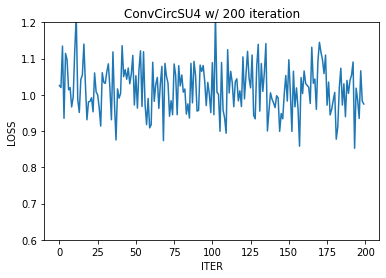

In [ ]:
# loss plot

# loss_list
# avg_loss_list
import matplotlib.pyplot as plt
plt.plot(loss_list)
plt.title(f"{conv_ansatz} w/ {str(iter_num)} iteration")
plt.xlabel("ITER")
plt.ylabel("LOSS")
plt.ylim((0.6, 1.2))

plt.show()
